In [1]:
threads=16
import os
os.environ['OMP_NUM_THREADS']=str(threads)
import torch

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pandas as pd
import urllib
import pickle
import rassp
from rassp import netutil
from rdkit import Chem

In [3]:
# XXX: needed by pickle.load of rassp models

from rassp import msutil,model
import sys
sys.modules['msutil'] = msutil
sys.modules['model'] = model

In [4]:
s = pd.read_parquet('rassp-public/sample_data/smallmols_cfm_pred_public_sample.parquet')

In [5]:
s.iloc[0].spect

array([array([15.02292522,  0.91388646]),
       array([25.00727602,  0.96256718]),
       array([27.02292522,  3.49654964]),
       array([29.03857442,  2.88757419]),
       array([39.02292522,  0.92641582]),
       array([41.03857442,  3.63968496]),
       array([42.04639902,  2.29737418]),
       array([43.05422362,  8.79653005]),
       array([43.97152142,  2.10668418]),
       array([44.06204822,  1.32544061]),
       array([44.97934602,  2.70170413]),
       array([45.06987282,  1.27590546]),
       array([55.05422362,  2.72504282]),
       array([58.98241922,  4.22013733]),
       array([59.99024382,  2.07733632]),
       array([69.06987282,  2.20343483]),
       array([70.07769742,  1.42581885]),
       array([71.08552202,  9.44191393]),
       array([84.99806842,  1.50804528]),
       array([86.00589302, 18.14332272]),
       array([87.01371762,  1.56864662]),
       array([88.02154222,  1.06527212]),
       array([114.0371914 ,   2.45328396]),
       array([129.0606652 ,   2.

In [63]:
# PredFeaturizer
sparse_spect = s.iloc[0].spect
record_spect = np.stack(sparse_spect)
spect_idx, spect_p, spect_out = self.spect_bin_config.histogram(record_spect[:, 0],
                                                                record_spect[:, 1])
spect_out = spect_out.astype(np.float32)


NameError: name 'self' is not defined

In [ ]:
s.iloc[0].spect_sparse

In [6]:
s.iloc[0]

mol_id                                              NIST2014_10006
inchi                InChI=1S/C6H11NS/c1-5(2)6(3)7-4-8/h5-6H,1-3H3
smiles                                              CC(C)C(C)N=C=S
rdmol            b'\xef\xbe\xad\xde\x00\x00\x00\x00\x0c\x00\x00...
cv_id                                                            7
morgan4_crc32                                           3981836209
spect            [[15.02292522, 0.9138864566], [25.00727602, 0....
spect_sparse     [[15.0, 0.9138864566], [25.0, 0.9625671785], [...
inchi_key                              YAVRRVJBEIYPRH-UHFFFAOYSA-N
Name: 0, dtype: object

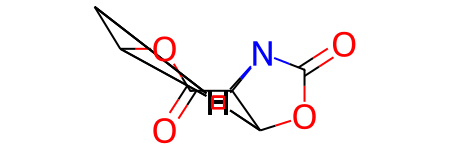

In [61]:
m = Chem.Mol(s.iloc[1].rdmol)
m

In [42]:
[ a.GetAtomicNum() for a in m.GetAtoms()]

[6, 6, 7, 6, 8, 7, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

### TODO 

Z toho pouziva RASSP jen spect a rdmol
rdmol je serializovany rdkit.Chem.Mol

to budeme umet z MSP vyrobit

In [ ]:
base='https://people.cs.uchicago.edu/~ericj/rassp/'
files=[ 'formulanet_best_candidate_pcsim_pretrain.nist-fromscratch-3x9x128.35790555.00000740.model',    
'formulanet_best_candidate_pcsim_pretrain.nist-fromscratch-3x9x128.35790555.meta',
'subsetnet_best_candidate_nist_fromscratch.nist-fromscratch-test01-old-1x2048.36688199.00001000.model', 
'subsetnet_best_candidate_nist_fromscratch.nist-fromscratch-test01-old-1x2048.36688199.meta',   
'subsetnet_best_candidate_nist_posttrain_cluster.cluster-nist-posttrain.35946017.00000480.model',
'subsetnet_best_candidate_nist_posttrain_cluster.cluster-nist-posttrain.35946017.meta']

for f in files:
    urllib.request.urlretrieve(f'{base}/{f}',f)

In [4]:
# from original run_rassp.py

use_gpu=True
model_dir='.'

MODELS = {
    'FormulaNet': {
        'checkpoint': os.path.join(model_dir, 'formulanet_best_candidate_pcsim_pretrain.nist-fromscratch-3x9x128.35790555.00000740.model'),
        'meta': os.path.join(model_dir, 'formulanet_best_candidate_pcsim_pretrain.nist-fromscratch-3x9x128.35790555.meta'),

        # NOTE(2023-01-24): FN currently has a reduced set of valid mol constraints bc this is what we trained with
        # and there is currently an outstanding bug where changing N_ATOMS here breaks FN predictions in subtle ways.
        'override_constraints': {
            'n_atom': 48,
            # 'n_formula': 4096,
            'n_formula': 32768,
            # 'n_subset': 12288,
            'n_subset': 49152,
        },
    },
    'SubsetNet': {
        'checkpoint': os.path.join(model_dir, 'subsetnet_best_candidate_nist_fromscratch.nist-fromscratch-test01-old-1x2048.36688199.00001000.model'),
        'meta': os.path.join(model_dir, 'subsetnet_best_candidate_nist_fromscratch.nist-fromscratch-test01-old-1x2048.36688199.meta'),

        # NOTE: this set of params works for SN GPU inference on a single RTX 2080 Ti (12GB VRAM)
        # despite SN being trained on <= 48 atoms like FN, it also scales well to mols up to <= 64 atoms (tested)
        'override_constraints': {
            'n_atom': 64,
            'n_formula': 32768,
            'n_subset': 49152,
        },
    },
}

model_name='FormulaNet'
meta_path = MODELS[model_name]['meta']
ckpt_path = MODELS[model_name]['checkpoint']
override_constraints = MODELS[model_name]['override_constraints']
meta = pickle.load(open(meta_path, 'rb'))

feat_config = meta['featurize_config']
for key, val in override_constraints.items():
    if key == 'n_atom':
        feat_config['MAX_N'] = val
    if key == 'n_formula':
        feat_config['explicit_formulae_config']['max_formulae'] = val
    if key == 'n_subset':
        feat_config['vert_subset_samples_n'] = val

if use_gpu and not torch.cuda.is_available():
    use_gpu = False

predictor = netutil.PredModel(
    meta_path,
    ckpt_path,
    USE_CUDA=use_gpu,
    data_parallel=False,
    featurize_config_update=feat_config,
)


In [5]:
smiles = ['C1=CNN=C1','CC(C)C#N','CCC(=C)C','CC[N+](=O)[O-]']*1000

valid_mols = [ Chem.AddHs(Chem.MolFromSmiles(s)) for s in smiles ]

In [6]:
predictions = predictor.pred(
    valid_mols,
    progress_bar=True,
    normalize_pred=True,
    output_hist_bins=True,
    batch_size=2, # XXX
    dataloader_config={
        'pin_memory': False,
        'num_workers': 0, # XXX
        'persistent_workers': False,
    },
    benchmark_dataloader=False,
)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [08:19<00:00,  8.02it/s]


In [ ]:
predictions['pred_binned'][0]

In [29]:
nist_path = '20210925_NIST_EI_MS_cleaned.msp'

from matchms.importing import load_from_msp
nist = list(load_from_msp(nist_path, metadata_harmonization=False))

In [30]:
len(nist)

350618

In [45]:
nist[42].metadata

{'formula': 'CH3F',
 'mw': '34',
 'casno': '593-53-3',
 'id': '43',
 'comment': 'SemiStdNP=173 StdNP=217 ; NIST MS# 41, Seq# M1969',
 'inchi': 'InChI=1S/CH3F/c1-2/h1H3',
 'inchikey': 'NBVXSUQYWXRMNV-UHFFFAOYSA-N',
 'iupac_name': 'fluoromethane',
 'smiles': 'CF',
 'num_peaks': '9',
 'compound_name': 'Methyl fluoride'}

In [47]:
nist[42].peaks.mz

array([12., 13., 14., 15., 31., 32., 33., 34., 35.])

In [51]:
nist[42].peaks.intensities

array([  5.  ,  11.99,  30.97, 115.9 ,  76.93,  43.96, 887.2 , 999.  ,
        11.99])

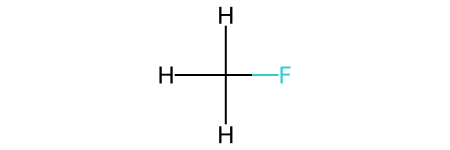

In [52]:
mol = Chem.AddHs(Chem.MolFromSmiles(nist[42].metadata['smiles']))
mol

In [53]:
b = mol.ToBinary()
b

b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\x00\x00\x00\x00\x00\x02\x00\x00\x00\x05\x00\x00\x00\x04\x00\x00\x00\x80\x01\x06 `\x00\x00\x00\x04\x03\t  \x00\x00\x00\x01\x01\x00(\x00\x00\x00\x00\x01\x01\x00(\x00\x00\x00\x00\x01\x01\x00(\x00\x00\x00\x00\x01\x0b\x00\x01\x00\x00\x02\x00\x00\x03\x00\x00\x04\x00\x14\x00\x00\x00\x00\x17\t\x00\x00\x00\x00\x00\x00\x00?\x00\x00\x00\x00\x12 \x00\x00\x00\x01\x00\x00\x00\x0f\x00\x00\x00__computedProps\x06\x00\x00\x00\x00\x00\x00\x00\x00\x13:\xd1\x00\x00\x00\x02\x00\x00\x00\x0f\x00\x00\x00__computedProps\x06\x01\x00\x00\x00\x00\x00\x00\x00\x0e\x00\x00\x00origNoImplicit\x0e\x00\x00\x00origNoImplicit\x03\x00\x02\x00\x00\x00\x0f\x00\x00\x00__computedProps\x06\x01\x00\x00\x00\x00\x00\x00\x00\x0e\x00\x00\x00origNoImplicit\x0e\x00\x00\x00origNoImplicit\x03\x00\x01\x00\x00\x00\n\x00\x00\x00isImplicit\x01\x01\x00\x00\x00\x01\x00\x00\x00\n\x00\x00\x00isImplicit\x01\x01\x00\x00\x00\x01\x00\x00\x00\n\x00\x00\x00isImplicit\x01\x01\x00\x00\x00\x13;\x10\x00\x00\x00

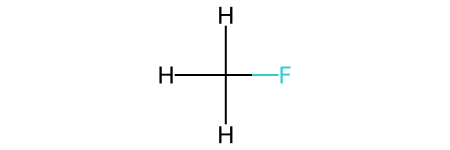

In [55]:
m2 = Chem.Mol(b)
m2

In [100]:
import numpy as np
a=np.stack([nist[42].peaks.mz,nist[42].peaks.intensities],axis=1)
a

array([[ 12.  ,   5.  ],
       [ 13.  ,  11.99],
       [ 14.  ,  30.97],
       [ 15.  , 115.9 ],
       [ 31.  ,  76.93],
       [ 32.  ,  43.96],
       [ 33.  , 887.2 ],
       [ 34.  , 999.  ],
       [ 35.  ,  11.99]])

In [110]:
bb = np.empty(shape=(a.shape[0],),dtype=object)
bb[:] = list(a)
bb

array([array([12.,  5.]), array([13.  , 11.99]), array([14.  , 30.97]),
       array([ 15. , 115.9]), array([31.  , 76.93]),
       array([32.  , 43.96]), array([ 33. , 887.2]), array([ 34., 999.]),
       array([35.  , 11.99])], dtype=object)

In [111]:
np.array(list(a),dtype=object)

array([[12.0, 5.0],
       [13.0, 11.99],
       [14.0, 30.97],
       [15.0, 115.9],
       [31.0, 76.93],
       [32.0, 43.96],
       [33.0, 887.2],
       [34.0, 999.0],
       [35.0, 11.99]], dtype=object)

In [99]:
n=nist[42]
np.array([ np.array(p,dtype=object) for p in zip(n.peaks.mz, n.peaks.intensities)])
#[ np.array(p) for p in zip(n.peaks.mz, n.peaks.intensities)]

array([[12.0, 5.0],
       [13.0, 11.99],
       [14.0, 30.97],
       [15.0, 115.9],
       [31.0, 76.93],
       [32.0, 43.96],
       [33.0, 887.2],
       [34.0, 999.0],
       [35.0, 11.99]], dtype=object)

In [200]:
def mkdf(nist2):
    mols = [ ]
    spects = []
    for i,n in enumerate(nist2):
        if n.metadata.get('smiles') is None:
            print(i,'no smiles')
            continue
        mol = Chem.MolFromSmiles(n.metadata['smiles'])
        if mol is None: 
            print(i,n.metadata['smiles'][:100],'... cant parse')
            continue 
        mol = Chem.AddHs(mol)
        if mol is None: 
            print(i.n.metadata['smiles'],'... cant add Hs')
            continue 
        mols.append(mol.ToBinary())
        a = np.stack([n.peaks.mz, n.peaks.intensities], axis=1)
        b = np.empty(shape=(a.shape[0],),dtype=object)
        b[:] = list(a)
        spects.append(b)

    df = pd.DataFrame.from_dict({ 'rdmol' : mols, 'spect' : spects })
    return df

In [214]:
%%capture
df = mkdf(nist[:20000:2])

In [215]:
df

,rdmol,spect
0,b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\x...,"[[1.0, 20.98], [2.0, 999.0]]"
1,b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\x...,"[[12.0, 37.97], [13.0, 105.9], [14.0, 203.82],..."
2,b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\x...,"[[12.0, 7.99], [13.0, 28.97], [14.0, 74.93], [..."
3,b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\x...,"[[1.0, 31.97], [12.0, 23.98], [13.0, 78.93], [..."
4,b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\x...,"[[16.0, 8.99], [17.0, 211.81], [18.0, 999.0], ..."
...,...,...
9840,b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\x...,"[[27.0, 23.98], [29.0, 62.94], [39.0, 9.99], [..."
9841,b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\x...,"[[26.0, 15.99], [27.0, 121.89], [28.0, 6.99], ..."
9842,b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\x...,"[[25.0, 2.0], [26.0, 44.96], [27.0, 297.73], [..."
9843,b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\x...,"[[13.0, 11.99], [14.0, 27.97], [15.0, 106.9], ..."


In [216]:
df.to_parquet('train.pq')

In [217]:
td = pd.read_parquet('train.pq')                    

In [218]:
td.iloc[0].spect

array([array([ 1.  , 20.98]), array([  2., 999.])], dtype=object)

In [219]:
%%capture
df = mkdf(nist[1:1000:2])
df.to_parquet('test.pq')

In [220]:
df

,rdmol,spect
0,b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\x...,"[[2.0, 14.99], [4.0, 999.0]]"
1,b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\x...,"[[12.0, 25.98], [13.0, 85.92], [14.0, 170.85],..."
2,b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\x...,"[[12.0, 25.98], [13.0, 74.93], [14.0, 152.86],..."
3,b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\x...,"[[14.0, 21.98], [15.0, 74.93], [16.0, 799.28],..."
4,b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\x...,"[[12.0, 6.99], [13.0, 31.97], [14.0, 1.0], [24..."
...,...,...
490,b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\x...,"[[14.0, 5.0], [15.0, 26.98], [16.0, 1.0], [17...."
491,b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\x...,"[[15.0, 28.97], [27.0, 37.97], [28.0, 11.99], ..."
492,b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\x...,"[[16.0, 25.98], [17.0, 79.93], [18.0, 361.67],..."
493,b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\x...,"[[12.0, 150.86], [13.0, 93.92], [14.0, 99.91],..."


In [176]:
sys.path.append('./rassp-public/rassp')
from forward_train import train

In [177]:
import yaml
with open('rassp-public/rassp/expconfig/demo.yaml') as cf:
    exp_config = yaml.load(cf,Loader=yaml.FullLoader)

In [224]:
exp_config['cluster_config']['data_dir'] = '.'
exp_config['DATALOADER_NUM_WORKERS'] = 8
exp_config['max_epochs'] = 10
exp_config['epoch_size'] = 10
exp_config['exp_data']['data'][0]['db_filename'] = 'train.pq'
exp_config['exp_data']['data'][1]['db_filename'] = 'test.pq'

with open('exp.yml','w') as y:
    yaml.dump(exp_config,y)

In [226]:
train('test',exp_config,exp_config_filename='exp.yml',USE_CUDA=True)

using checkpoint_dir: checkpoints
we are training with 9845
we are testing with 495
it took 0.1s to load the data
{'init_noise': 0.01, 'init_bias': 0.0, 'resnet': True, 'int_d': 512, 'layer_n': 16, 'agg_func': 'goodmax', 'gml_class': 'GraphMatLayersNormAfterRes', 'gml_config': {'layer_class': 'GraphMatLayerFast3', 'layer_config': {'dropout': 0.0, 'nonlin': 'leakyrelu', 'swap_init': False}}, 'g_feature_n': 45, 'inner_norm': 'layer', 'input_norm': 'batch', 'spect_out_class': 'MolAttentionGRU', 'spect_out_config': {'formula_oh_sizes': [50, 46, 30, 30, 30, 30, 30, 30], 'formula_oh_accum': True, 'internal_d': 128, 'embedding_key_size': 8, 'gru_layer_n': 3, 'linear_layer_n': 9}, 'GS': 4, 'spect_bin': <rassp.msutil.binutils.SpectrumBins object at 0x7fa6e2d07b80>}


/opt/conda/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


GCN module had 15869952 nparams
Spectral module had 3862321 nparams
Net overall had 19732363 nparams
NOT LOADING FROM ANY CHECKPOINT
NOT USING CUSTOM COLLATE_FN
gml.gl.0.weight                                     (4, 512, 45) 
gml.gl.0.bias                                       (4, 1, 1, 51 
gml.gl.1.weight                                     (4, 512, 512 
gml.gl.1.bias                                       (4, 1, 1, 51 
gml.gl.2.weight                                     (4, 512, 512 
gml.gl.2.bias                                       (4, 1, 1, 51 
gml.gl.3.weight                                     (4, 512, 512 
gml.gl.3.bias                                       (4, 1, 1, 51 
gml.gl.4.weight                                     (4, 512, 512 
gml.gl.4.bias                                       (4, 1, 1, 51 
gml.gl.5.weight                                     (4, 512, 512 
gml.gl.5.bias                                       (4, 1, 1, 51 
gml.gl.6.weight                                

train: 100%|███████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.33it/s]
                                                                                                                 
 70%|█████████████████████████████████████████████████████▉                       | 7/10 [00:13<00:05,  1.88s/it]


KeyError: Caught KeyError in DataLoader worker process 1.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 49, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 49, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/build/rassp/dataset/__init__.py", line 95, in __getitem__
    features_dict = self.featurizer(mol)
  File "/build/rassp/featurize/featurize.py", line 126, in __call__
    formulae_feats, formulae_peaks = self.pff(mol)
  File "/build/rassp/featurize/molecule_features.py", line 640, in __call__
    formulae, masses = self.ffe.get_frag_formulae(mol)
  File "/build/rassp/msutil/masscompute.py", line 94, in get_frag_formulae
    np_out = masseval.py_get_all_frag_spect_highres(formula_dict ,
  File "rassp/msutil/masseval.pyx", line 325, in rassp.masseval.py_get_all_frag_spect_highres
  File "rassp/msutil/masseval.pyx", line 327, in rassp.masseval.py_get_all_frag_spect_highres
  File "rassp/msutil/masseval.pyx", line 149, in rassp.masseval.Formula.__cinit__
KeyError: 35
